<a href="https://colab.research.google.com/github/francescostreet/ShreckCiuchino2026/blob/Branch-Sereno/conv_embedding_corrected_layer_choice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**




In [1]:
# @title
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/Challenge1-Datasets"
%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Challenge1-Datasets


## ⚙️ **Libraries Import**

In [2]:
# @title
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
import torch.nn.functional as F # Import torch.nn.functional
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [3]:
# @title
import pandas as pd

current_dir = '/gdrive/My Drive/Challenge1-Datasets'

X_train = pd.read_csv(os.path.join(current_dir, 'pirate_pain_train.csv'))
y_train = pd.read_csv(os.path.join(current_dir, 'pirate_pain_train_labels.csv'))
X_test = pd.read_csv(os.path.join(current_dir, 'pirate_pain_test.csv'))

## 🔎 **Exploration and Data Analysis**

In [4]:
# @title
# Define column names for the dataset
column_names = ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'] + [f'joint_{ind:02d}' for ind in range(31)]

# Read the dataset into a DataFrame with specified column names
df = pd.read_csv('pirate_pain_train.csv', header=0, names=column_names)

# Merge df with y_train (the original labels DataFrame) to add the 'label' column
df = pd.merge(df, y_train, on='sample_index', how='left')

# Read the test dataset into a DataFrame with specified column names
df_test = pd.read_csv('pirate_pain_test.csv', header=0, names=column_names)

# Remove rows with any missing values
df.dropna(axis=0, how='any', inplace=True)

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Display the first 10 rows of the DataFrame
display(df.head(10))

DataFrame shape: (105760, 41)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5,no_pain
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5,no_pain
7,0,7,2,2,2,2,two,two,two,1.038597,...,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5,no_pain
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5,no_pain
9,0,9,0,2,2,2,two,two,two,1.054999,...,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5,no_pain


In [5]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

# Data manipulation

In [6]:
#Define a dictionary for n_legs, n_hands, n_eyes
legs_dictionary = df['n_legs'].unique()
hands_dictionary = df['n_hands'].unique()
eyes_dictionary = df['n_eyes'].unique()
print("Unique strings in 'n_legs' column:")
print(legs_dictionary)
print("Unique strings in 'n_hands' column:")
print(hands_dictionary)
print("Unique strings in 'n_eyes' column:")
print(eyes_dictionary)

Unique strings in 'n_legs' column:
['two' 'one+peg_leg']
Unique strings in 'n_hands' column:
['two' 'one+hook_hand']
Unique strings in 'n_eyes' column:
['two' 'one+eye_patch']


In [7]:
n_cols = ['n_legs', 'n_hands', 'n_eyes']
mapping = {
    'two': 2,
    'one+peg_leg': 1,
    'one+hook_hand': 1,
    'one+eye_patch': 1
}

for col in n_cols:
    df[col] = df[col].map(mapping).astype(np.float32)
    df_test[col] = df_test[col].map(mapping).astype(np.float32)

for i in range(31):
  df[f'joint_{i:02d}']= df[f'joint_{i:02d}'].astype(np.float32)
  df_test[f'joint_{i:02d}']= df_test[f'joint_{i:02d}'].astype(np.float32)

# Drop the constant 'joint_30' column from both df and df_test
#if 'joint_30' in df.columns:
 #   df = df.drop('joint_30', axis=1)
  #  print("Dropped 'joint_30' from df.")
#if 'joint_30' in df_test.columns:
 #   df_test = df_test.drop('joint_30', axis=1)
  #  print("Dropped 'joint_30' from df_test.")

numeric_cols = df.select_dtypes(include='number').columns
numeric_cols_test = df_test.select_dtypes(include='number').columns

# Calcola la varianza per ogni colonna
variance = df[numeric_cols].var()
variance_test = df_test[numeric_cols].var()

# Seleziona solo le colonne con varianza > 0
cols_to_keep = variance[variance > 1e-3].index
cols_to_keep_test = variance[variance > 1e-3].index

# Crea un nuovo dataframe senza le colonne costanti
df_temp = df[cols_to_keep]
df_test_temp = df_test[cols_to_keep_test]

df = df_temp
df_test = df_test_temp

# Display updated DataFrame information to confirm the changes
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  float32
 7   n_hands        105760 non-null  float32
 8   n_eyes         105760 non-null  float32
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

In [8]:
# Merge df with y_train (the original labels DataFrame) to add the 'label' column
df = pd.merge(df, y_train, on='sample_index', how='left')

# Remove rows with any missing values
df.dropna(axis=0, how='any', inplace=True)
df_test.dropna(axis=0, how='any', inplace=True)

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")
print(f"Test DataFrame shape: {df_test.shape}")

# Display the first 10 rows of the DataFrame
display(df.head(10))
display(df_test.head(10))

DataFrame shape: (105760, 27)
Test DataFrame shape: (211840, 26)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label
0,0,0,2,0,2,1,2.0,2.0,2.0,1.094705,...,0.712989,1.050142,0.529555,0.447370,1.091046,0.017592,0.013508,0.026798,0.027815,no_pain
1,0,1,2,2,2,2,2.0,2.0,2.0,1.135183,...,0.722685,1.060313,0.446810,0.414432,1.045862,0.013352,0.000000,0.013377,0.013716,no_pain
2,0,2,2,0,2,2,2.0,2.0,2.0,1.080745,...,0.668043,1.011410,0.432499,0.431535,1.088221,0.016225,0.008110,0.024097,0.023105,no_pain
3,0,3,2,2,2,2,2.0,2.0,2.0,0.938017,...,0.702085,1.047223,0.478806,0.420665,1.096833,0.011832,0.007450,0.028613,0.024648,no_pain
4,0,4,2,2,2,2,2.0,2.0,2.0,1.090185,...,0.712197,1.044731,0.452906,0.476537,1.103968,0.005360,0.002532,0.033026,0.025328,no_pain
5,0,5,2,0,2,1,2.0,2.0,2.0,1.146031,...,0.646228,1.056162,0.547064,0.464709,1.143319,0.006150,0.006444,0.033101,0.023767,no_pain
6,0,6,2,1,2,1,2.0,2.0,2.0,1.025870,...,0.734906,1.042529,0.445074,0.474467,1.063973,0.006495,0.006421,0.031804,0.019056,no_pain
7,0,7,2,2,2,2,2.0,2.0,2.0,1.038597,...,0.636691,0.996125,0.468641,0.463964,1.145227,0.015998,0.005397,0.035552,0.015732,no_pain
8,0,8,2,2,0,1,2.0,2.0,2.0,0.984251,...,0.735875,0.986229,0.454055,0.478525,1.101066,0.020539,0.008517,0.008635,0.015257,no_pain
9,0,9,0,2,2,2,2.0,2.0,2.0,1.054999,...,0.612981,0.991768,0.506058,0.419849,1.050455,0.007682,0.021383,0.034006,0.028966,no_pain


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
0,0,0,2,2,2,2,2.0,2.0,2.0,0.842535,...,0.950154,1.057105,1.061014,0.327447,0.253370,1.177406,0.019372,0.066324,0.022228,0.013576
1,0,1,2,2,2,2,2.0,2.0,2.0,0.898836,...,0.993922,1.105165,1.015887,0.331900,0.294067,0.985953,0.069747,0.080417,0.023650,0.038793
2,0,2,2,2,2,2,2.0,2.0,2.0,0.957765,...,0.982370,1.142910,1.032120,0.384204,0.272972,1.059171,0.054968,0.058811,0.027023,0.054202
3,0,3,1,2,2,2,2.0,2.0,2.0,0.832596,...,0.944723,1.057460,1.013968,0.381349,0.283902,1.132100,0.048695,0.047128,0.016151,0.024983
4,0,4,2,2,2,0,2.0,2.0,2.0,0.805972,...,0.948609,1.008785,0.974159,0.380332,0.311384,0.980731,0.019762,0.031116,0.015618,0.017931
5,0,5,2,2,0,2,2.0,2.0,2.0,0.805308,...,1.025050,1.050914,1.023095,0.310682,0.209324,0.936655,0.037433,0.034157,0.013880,0.033762
6,0,6,2,2,0,2,2.0,2.0,2.0,0.878559,...,0.926120,1.054816,1.030822,0.309517,0.300793,1.135787,0.076399,0.025877,0.049272,0.037960
7,0,7,2,2,2,2,2.0,2.0,2.0,0.847666,...,0.944574,1.041811,0.956960,0.376977,0.279399,1.022974,0.041566,0.055916,0.024414,0.026338
8,0,8,2,2,2,1,2.0,2.0,2.0,0.913557,...,1.022430,1.044301,1.014973,0.351867,0.279328,1.138381,0.040049,0.047536,0.018454,0.010675
9,0,9,2,2,2,0,2.0,2.0,2.0,0.880579,...,0.953042,1.080148,1.009135,0.312861,0.364807,1.049919,0.022977,0.096785,0.035494,0.023898


In [9]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,1.990923,1.990923,1.990923,0.943095,...,0.837427,0.849700,0.909554,0.694840,0.691105,1.047288,0.041905,0.058244,0.049886,0.062273
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.094795,0.094795,0.094795,0.202049,...,0.237901,0.180488,0.180319,0.257571,0.262644,0.110833,0.060292,0.079820,0.060773,0.072597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.122095,0.004671,0.107917,0.072233,0.107136,0.000203,0.000000,0.000000,0.000000
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.828277,...,0.781375,0.717725,0.825898,0.469688,0.460407,0.983152,0.009885,0.012652,0.016290,0.019638
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.005126,...,0.904914,0.831221,0.940954,0.690806,0.705150,1.057917,0.021898,0.031739,0.031843,0.039041
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.081039,...,0.984410,0.991104,1.030941,0.866482,0.851772,1.124471,0.048579,0.071051,0.058741,0.079518
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.407968,...,1.361969,1.357288,1.388105,1.631494,1.464157,1.396754,1.223617,1.187419,1.412037,1.370765


# Graphs

Extracted 4 pain survey columns.
First 5 rows of the new pain_survey_df:
Counts of 0, 1, and 2 for each pain_survey column:
pain_survey_1: {0: 12352, 1: 14031, 2: 79377}
pain_survey_2: {0: 11760, 1: 12983, 2: 81017}
pain_survey_3: {0: 11529, 1: 13573, 2: 80658}
pain_survey_4: {0: 11361, 1: 12905, 2: 81494}
Total aggregated counts of 0, 1, and 2 across all pain_survey columns:
{0: 47002, 1: 53492, 2: 322546}


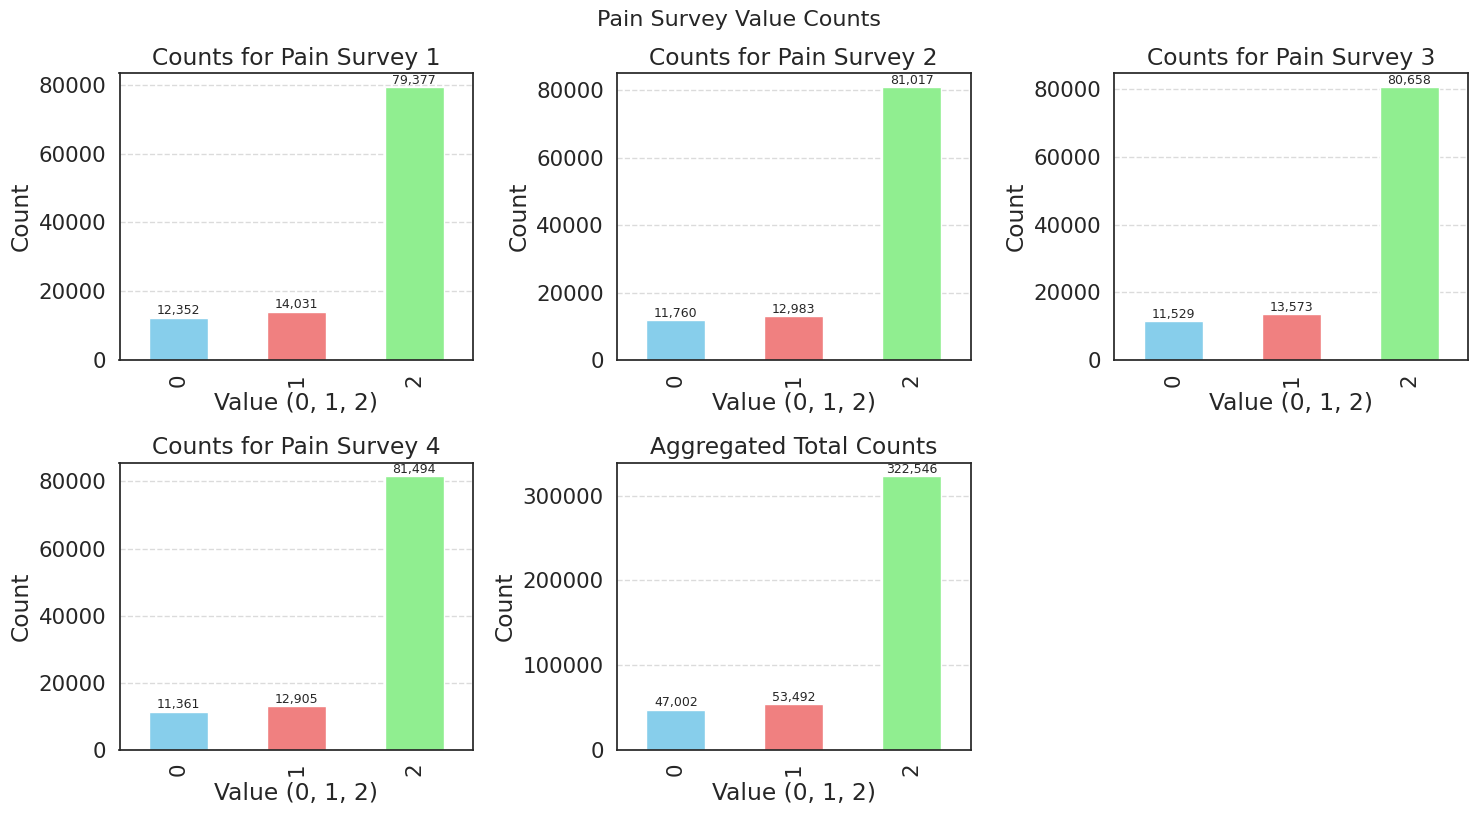

In [10]:
# @title
pain_survey_columns = [col for col in df.columns if col.startswith('pain_survey')]
pain_survey_df = df[pain_survey_columns]

print(f"Extracted {len(pain_survey_columns)} pain survey columns.")
print("First 5 rows of the new pain_survey_df:")
pain_survey_df.head()

pain_counts = {}
for col in pain_survey_columns:
    counts = pain_survey_df[col].value_counts().reindex([0, 1, 2], fill_value=0)
    pain_counts[col] = counts.to_dict()

print("Counts of 0, 1, and 2 for each pain_survey column:")
for col, counts in pain_counts.items():
    print(f"{col}: {counts}")

total_pain_counts = {0: 0, 1: 0, 2: 0}
for col, counts in pain_counts.items():
    for value, count in counts.items():
        total_pain_counts[value] += count

print("Total aggregated counts of 0, 1, and 2 across all pain_survey columns:")
print(total_pain_counts)

num_pain_surveys = len(pain_survey_columns)
num_plots = num_pain_surveys + 1 # +1 for the aggregated total

# Determine grid size for subplots dynamically
# For 5 plots, a 2x3 grid works well, leaving one empty spot
if num_plots <= 3:
    ncols = num_plots
    nrows = 1
elif num_plots <= 6:
    ncols = 3
    nrows = (num_plots + ncols - 1) // ncols
else:
    ncols = 4
    nrows = (num_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten() # Flatten the array of axes for easy iteration

# Plot individual pain_survey column counts
for i, col in enumerate(pain_survey_columns):
    counts_series = pd.Series(pain_counts[col])
    counts_series.plot(kind='bar', ax=axes[i], color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_title(f'Counts for {col.replace("_", " ").title()}')
    axes[i].set_xlabel('Value (0, 1, 2)')
    axes[i].set_ylabel('Count')
    axes[i].ticklabel_format(style='plain', axis='y') # Disable scientific notation
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

# Plot aggregated total counts
total_counts_series = pd.Series(total_pain_counts)
total_counts_series.plot(kind='bar', ax=axes[num_pain_surveys], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[num_pain_surveys].set_title('Aggregated Total Counts')
axes[num_pain_surveys].set_xlabel('Value (0, 1, 2)')
axes[num_pain_surveys].set_ylabel('Count')
axes[num_pain_surveys].ticklabel_format(style='plain', axis='y') # Disable scientific notation
axes[num_pain_surveys].grid(axis='y', linestyle='--', alpha=0.7)
for p in axes[num_pain_surveys].patches:
    axes[num_pain_surveys].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

# Hide any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Pain Survey Value Counts', y=1.02, fontsize=16)
plt.show()

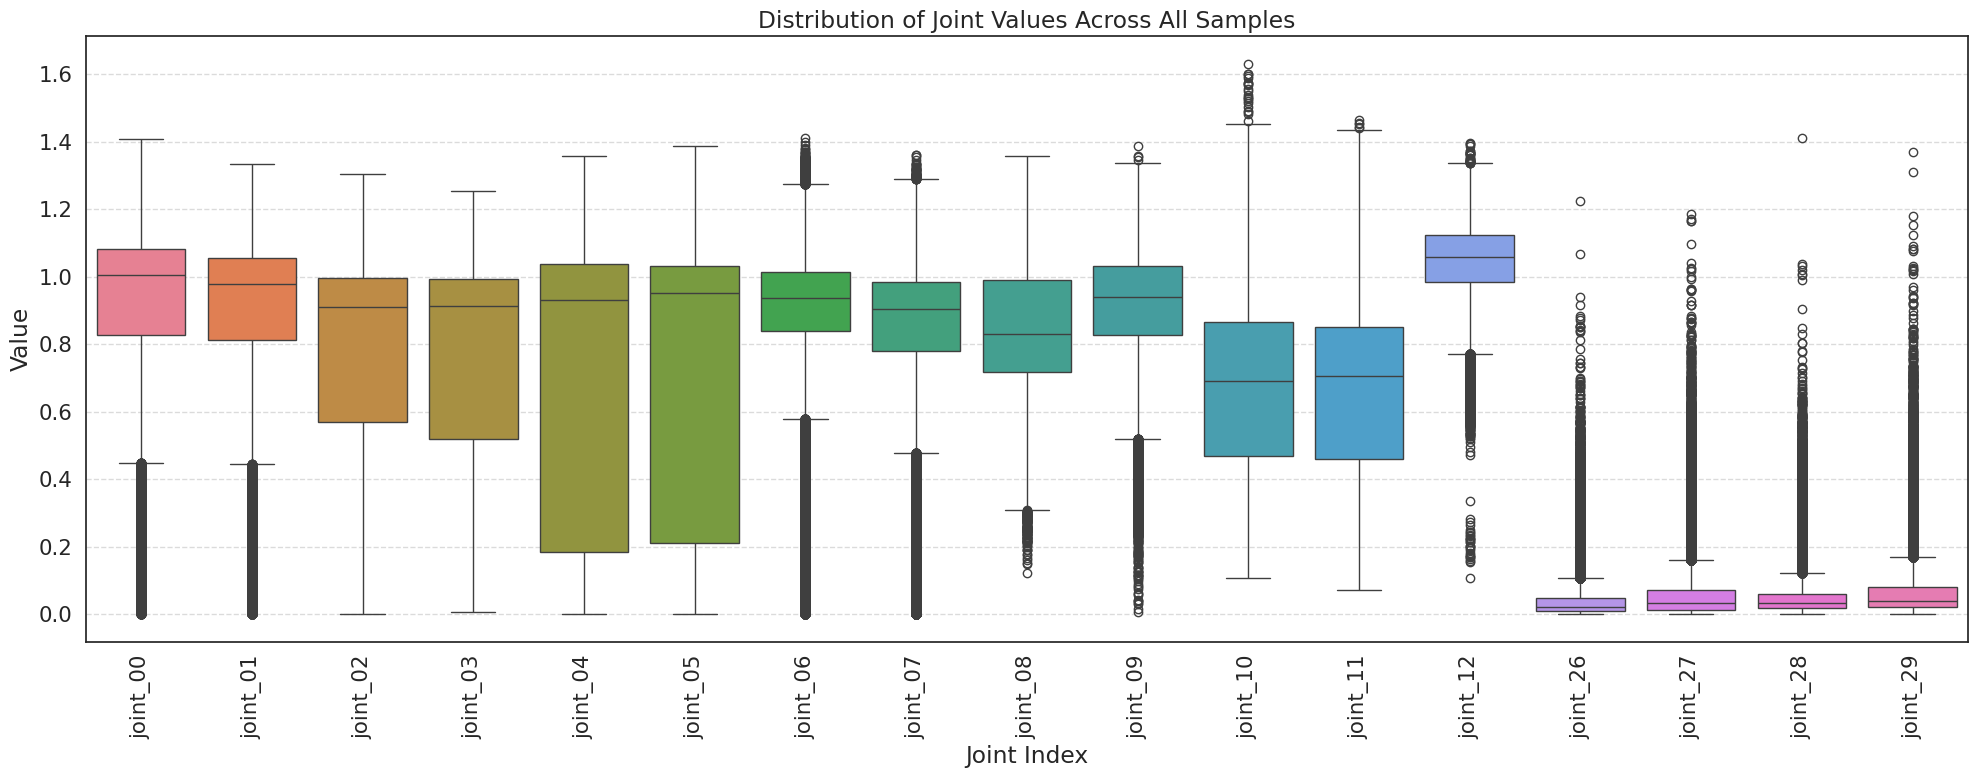

In [11]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

# Identify all joint columns
joint_columns = [col for col in df.columns if col.startswith('joint_')]

# Create a box plot for each joint column
plt.figure(figsize=(20, 8)) # Adjust figure size for better readability
sns.boxplot(data=df[joint_columns])
plt.title('Distribution of Joint Values Across All Samples')
plt.xlabel('Joint Index')
plt.ylabel('Value')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data analysis & pre-processing





In [12]:
unique_pirates = df['sample_index'].unique()
n_pirates = len(unique_pirates)
print(f"Total number of pirates in the dataset: {n_pirates}")

random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_pirates)

# Define the number of users for validation and test sets
N_VAL_USERS = 135 # You can change this number

# Calculate the number of users for the training set
n_train_users = len(unique_pirates) - N_VAL_USERS

# Split the shuffled user IDs into training and validation
train_users = unique_pirates[:n_train_users]
val_users = unique_pirates[n_train_users:n_train_users + N_VAL_USERS]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]

# Print the shapes of the training, validation, and test sets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Total number of pirates in the dataset: 661
Training set shape: (84160, 27)
Validation set shape: (21600, 27)


In [13]:
# Define the columns to be normalised
# Exclude pain_survey_X from scaling, as they will be embedded as categorical features
scale_columns = ['n_legs', 'n_hands', 'n_eyes'] + [f'joint_{ind:02d}' for ind in range(13)] + ['joint_26', 'joint_27', 'joint_28', 'joint_29',]

# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set and ensure float32
    df_train[column] = ((df_train[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

    # Normalise the validation set and ensure float32
    df_val[column] = ((df_val[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

    # Normalise the test set and ensure float32
    df_test[column] = ((df_test[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

In [14]:
# === Estrarre feature statiche per sample_index (una riga per soggetto) ===
static_cols = ['n_legs', 'n_hands', 'n_eyes']
STATIC_COLS= static_cols

# Assicurati che df_train, df_val, df_test esistano già (li hai creato poco sopra)
static_train_df = df_train.groupby('sample_index')[static_cols].first().astype(np.float32)
static_val_df   = df_val.groupby('sample_index')[static_cols].first().astype(np.float32)
static_test_df  = df_test.groupby('sample_index')[static_cols].first().astype(np.float32)

In [15]:
# Display the first five rows of the training DataFrame
print(df_train.shape)
df_train.head()

(84160, 27)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label
0,0,0,2,0,2,1,1.0,1.0,1.0,0.777507,...,0.478382,0.755707,0.276742,0.269510,0.762947,0.014211,0.011376,0.018978,0.020291,no_pain
1,0,1,2,2,2,2,1.0,1.0,1.0,0.806256,...,0.486231,0.763060,0.222432,0.245846,0.727910,0.010745,0.000000,0.009473,0.010006,no_pain
2,0,2,2,0,2,2,1.0,1.0,1.0,0.767592,...,0.441994,0.727711,0.213039,0.258133,0.760757,0.013093,0.006830,0.017065,0.016856,no_pain
3,0,3,2,2,2,2,1.0,1.0,1.0,0.666220,...,0.469554,0.753597,0.243433,0.250324,0.767434,0.009502,0.006274,0.020264,0.017981,no_pain
4,0,4,2,2,2,2,1.0,1.0,1.0,0.774297,...,0.477740,0.751796,0.226434,0.290464,0.772967,0.004212,0.002132,0.023389,0.018477,no_pain


In [16]:
# Display the first five rows of the test DataFrame
print(df_test.shape)
df_test.head()

(211840, 26)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
0,0,0,2,2,2,2,1.0,1.0,1.0,0.598405,...,0.697633,0.756975,0.763566,0.144088,0.130134,0.829913,0.015666,0.055856,0.015742,0.009904
1,0,1,2,2,2,2,1.0,1.0,1.0,0.638393,...,0.729769,0.795884,0.730947,0.147011,0.159372,0.681456,0.056841,0.067724,0.016749,0.028300
2,0,2,2,2,2,2,1.0,1.0,1.0,0.680247,...,0.721287,0.826442,0.742680,0.181341,0.144217,0.738230,0.044761,0.049528,0.019138,0.039542
3,0,3,1,2,2,2,1.0,1.0,1.0,0.591346,...,0.693645,0.757262,0.729559,0.179467,0.152069,0.794781,0.039633,0.039690,0.011438,0.018225
4,0,4,2,2,2,0,1.0,1.0,1.0,0.572436,...,0.696499,0.717856,0.700784,0.178800,0.171814,0.677406,0.015984,0.026205,0.011061,0.013081


In [17]:
# Define a mapping of activity names to integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

# Map activity names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map activity names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

# Model definition

In [18]:
WINDOW_SIZE= 60 # I wouldn't exceed 180 since each "activity" is composed by 180 measures, by
STRIDE= 20 # random first guess

In [19]:
# @title
# Define a function to build sequences from the dataset
def build_sequences(df, window=WINDOW_SIZE, stride=STRIDE, return_labels=True, feature_columns_to_extract=None, pain_survey_columns_to_extract=None):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    main_features_dataset = []
    pain_survey_features_dataset = [] # New list for pain survey features
    labels = []
    sequence_ids = [] # New list to store sample_index for each sequence

    # Always use 'sample_index' as the ID column as per user request
    id_column = 'sample_index'

    # Always use 'label' as the label column as per user request
    label_column = 'label'

    # Use provided feature_columns_to_extract or default to all 'joint_' columns if not specified
    if feature_columns_to_extract is None:
        # Default to all joint and static columns if not explicitly provided
        feature_columns_to_extract = [col for col in df.columns if col.startswith('joint_')] + STATIC_COLS

    if not feature_columns_to_extract:
        raise ValueError("No main feature columns provided or found for sequence building.")

    # Ensure pain_survey_columns_to_extract is a list if provided
    if pain_survey_columns_to_extract is None:
        pain_survey_columns_to_extract = []
    elif isinstance(pain_survey_columns_to_extract, str):
        pain_survey_columns_to_extract = [pain_survey_columns_to_extract]


    for current_id in df[id_column].unique():
        # Filter dataframe for the current ID and sort by time
        user_data = df[df[id_column] == current_id].sort_values(by='time')

        # Extract main sensor data for the current ID
        temp_main_data = user_data[feature_columns_to_extract].values

        # Extract pain survey data for the current ID
        temp_pain_survey_data = user_data[pain_survey_columns_to_extract].values if pain_survey_columns_to_extract else np.empty((len(user_data), 0))

        # Handle cases where a user might have no data points (empty temp_data)
        if len(temp_main_data) == 0:
            continue

        current_label = None
        if return_labels:
            if label_column in df.columns:
                current_label = user_data[label_column].values[0] # Label is per-pirate, so take first
            else:
                raise KeyError(f"Label column '{label_column}' not found in DataFrame for ID {current_id} when labels are expected (return_labels=True).")

        # Calculate padding length to ensure full windows
        padding_len = window - (len(temp_main_data) % window)
        if padding_len == window: # If len(temp_main_data) is a multiple of window, no padding needed
            padding_len = 0

        # Create zero padding and concatenate with the data
        if padding_len > 0:
            padding_main = np.zeros((padding_len, temp_main_data.shape[1]), dtype='float32')
            temp_main_data = np.concatenate((temp_main_data, padding_main))
            if temp_pain_survey_data.shape[1] > 0:
                padding_ps = np.zeros((padding_len, temp_pain_survey_data.shape[1]), dtype=temp_pain_survey_data.dtype)
                temp_pain_survey_data = np.concatenate((temp_pain_survey_data, padding_ps))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp_main_data):
            main_features_dataset.append(temp_main_data[idx:idx + window])

            # Extract pain survey features for the *first timestep* of the current window
            if temp_pain_survey_data.shape[1] > 0:
                pain_survey_features_dataset.append(temp_pain_survey_data[idx]) # Take the pain survey at the start of the window
            else:
                pain_survey_features_dataset.append(np.empty(0, dtype=np.int64)) # Empty array if no PS features

            if return_labels:
                labels.append(current_label) # Append the actual label (per pirate)
            else:
                labels.append(-1) # Placeholder

            sequence_ids.append(current_id) # Append the current_id for each sequence
            idx += stride

    main_features_np = np.array(main_features_dataset)
    # Ensure pain_survey_features_np has correct shape even if no PS features
    if len(pain_survey_features_dataset) > 0 and (len(pain_survey_features_dataset[0]) > 0):
        pain_survey_features_np = np.array(pain_survey_features_dataset)
    else:
        pain_survey_features_np = np.empty((len(main_features_dataset), 0), dtype=np.int64)

    labels_np = np.array(labels, dtype=np.int64) if return_labels else np.empty(0, dtype=np.int64)
    sequence_ids_np = np.array(sequence_ids)

    return main_features_np, pain_survey_features_np, labels_np, sequence_ids_np

In [21]:
# @title

# New parameters for pain survey embeddings
PAIN_SURVEY_FEATURES = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

# Get the list of all feature columns (dynamic + static)
all_feature_columns_global = [col for col in df_train.columns if col.startswith('joint_')] + STATIC_COLS

# Pain survey columns
pain_survey_cols_global = PAIN_SURVEY_FEATURES

# Generate sequences and labels for the training set
X_train, X_train_ps_sequences, y_train, seq_ids_train = build_sequences(df_train, WINDOW_SIZE, STRIDE,
                                                                         feature_columns_to_extract=all_feature_columns_global,
                                                                         pain_survey_columns_to_extract=pain_survey_cols_global)

# Generate sequences and labels for the validation set
X_val, X_val_ps_sequences, y_val, seq_ids_val     = build_sequences(df_val, WINDOW_SIZE, STRIDE,
                                                                     feature_columns_to_extract=all_feature_columns_global,
                                                                     pain_survey_columns_to_extract=pain_survey_cols_global)

# Generate sequences for the test set (without labels)
X_test, X_test_ps_sequences, _, seq_ids_test       = build_sequences(df_test, WINDOW_SIZE, STRIDE, return_labels=False,
                                                                     feature_columns_to_extract=all_feature_columns_global,
                                                                     pain_survey_columns_to_extract=pain_survey_cols_global)

# Print the shapes of the generated datasets and their labels
print(f"X_train shape: {X_train.shape}, X_train_ps_sequences shape: {X_train_ps_sequences.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, X_val_ps_sequences shape: {X_val_ps_sequences.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, X_test_ps_sequences shape: {X_test_ps_sequences.shape}")
print(f"seq_ids_test shape: {seq_ids_test.shape}")

X_train shape: (3682, 60, 20), X_train_ps_sequences shape: (3682, 4), y_train shape: (3682,)
X_val shape: (945, 60, 20), X_val_ps_sequences shape: (945, 4), y_val shape: (945,)
X_test shape: (9268, 60, 20), X_test_ps_sequences shape: (9268, 4)
seq_ids_test shape: (9268,)


In [22]:
# The static features (n_legs, n_hands, n_eyes) are now integrated into the X_train/val/test sequences directly.
# The previous logic for pain survey features was treating them as static per pirate, which was incorrect.
# Now, pain survey features are extracted per window by the build_sequences function.

# These print statements refer to global variables that will be set by the previous step.
print("X_train_ps_sequences shape:", X_train_ps_sequences.shape)
print("X_val_ps_sequences shape:", X_val_ps_sequences.shape)
print("X_test_ps_sequences shape:", X_test_ps_sequences.shape)


X_train_ps_sequences shape: (3682, 4)
X_val_ps_sequences shape: (945, 4)
X_test_ps_sequences shape: (9268, 4)


In [23]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [24]:
train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(X_train_ps_sequences).long(),
    torch.from_numpy(y_train).long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(X_val_ps_sequences).long(),
    torch.from_numpy(y_val).long()
)
# test dataset (no label)
test_ds = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(X_test_ps_sequences).long()
)

In [25]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 32 #in this course don't exceed this, isn't useful

In [26]:
def make_loader(ds, batch_size, shuffle=True, drop_last=False, sampler=None):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle if sampler is None else False, # Disable shuffle if a sampler is provided
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
        sampler=sampler # Pass the sampler if provided
    )

In [ ]:
# @title
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler

# Calculate class weights for WeightedRandomSampler based on y_train
# y_train is from the build_sequences output (numpy array of labels for each window)
class_sample_count = np.array([(y_train == t).sum() for t in np.unique(y_train)])

# Calculate class weights as total number of samples divided by class sample count
# This scales up the weights compared to 1.0 / count, but maintains relative proportions.
total_samples_in_y_train = len(y_train)
class_weights_sampler = total_samples_in_y_train / class_sample_count

# Create a weight for each sample in train_ds based on its class weight
# y_train_tensor is the labels part of train_ds, but y_train (numpy) is easier to work with here
samples_weight = np.array([class_weights_sampler[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight).float()

# Create the WeightedRandomSampler
train_sampler = WeightedRandomSampler(
    weights=np.sqrt(samples_weight),
    num_samples=len(samples_weight),
    replacement=True # Typically replacement=True for WeightedRandomSampler
)

# Create data loaders with different settings for each phase
# Use the sampler for the training loader to handle class imbalance
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle= True, drop_last=False)
# For validation, we typically want to evaluate on the true distribution, so no sampler is used.
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [27]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [28]:
for xb, xb_ps, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Pain survey features batch shape:", xb_ps.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([32, 60, 20])
Pain survey features batch shape: torch.Size([32, 4])
Labels batch shape: torch.Size([32])


# 🛠️ Model Building

In [29]:
# @title
def recurrent_summary(model, input_size, static_input_size=0):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
        static_input_size (int): Number of static features, if any. Defaults to 0.
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create dummy input tensors with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)
    dummy_static_input = None
    if static_input_size > 0:
        dummy_static_input = torch.randn(1, static_input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            if dummy_static_input is not None:
                model(dummy_input, dummy_static_input)
            else:
                model(dummy_input) # If no static input, call with only dynamic input
        except Exception as e:
            print(f"Error during dummy forward pass in recurrent_summary: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [30]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2,
            pain_survey_embedding_dims=None, # Reintroduced for separate embedding
            conv1d_out_channels=0,
            conv1d_kernel_size=0,
            conv1d_padding=0
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        self.pain_survey_embedding_dims = pain_survey_embedding_dims

        self.conv1d_out_channels = conv1d_out_channels
        self.conv1d_kernel_size = conv1d_kernel_size
        self.conv1d_padding = conv1d_padding

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Calculate the actual input size for the RNN, now including combined dynamic and static features
        rnn_input_size_pre_conv = input_size

        # Define the Conv1d layer if conv1d_out_channels is specified
        if self.conv1d_out_channels > 0:
            self.conv1d_layer = nn.Conv1d(
                in_channels=rnn_input_size_pre_conv,
                out_channels=self.conv1d_out_channels,
                kernel_size=self.conv1d_kernel_size,
                padding=self.conv1d_padding
            )
            rnn_input_size_actual = self.conv1d_out_channels # RNN input becomes Conv1d output channels
        else:
            rnn_input_size_actual = rnn_input_size_pre_conv # No Conv1d, so direct input to RNN

        # Pain Survey Embeddings (Reintroduced)
        self.pain_survey_embedding_output_size = 0
        if self.pain_survey_embedding_dims is not None:
            self.pain_survey_embedding_layers = nn.ModuleList([
                nn.Embedding(num_embeddings=3, embedding_dim=emb_dim) # Each pain survey has 3 possible values (0, 1, 2)
                for emb_dim in self.pain_survey_embedding_dims
            ])
            self.pain_survey_embedding_output_size = sum(self.pain_survey_embedding_dims)

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=rnn_input_size_actual, # Use the combined input size (potentially after Conv1d)
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the hidden_to_classify (after RNN)
        if self.bidirectional:
            classifier_input_size_from_rnn = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size_from_rnn = hidden_size

        # Calculate input size for the final classifier, incorporating pain survey embeddings
        final_classifier_input_size = classifier_input_size_from_rnn
        if self.pain_survey_embedding_output_size > 0: # Reintroduced
            final_classifier_input_size += self.pain_survey_embedding_output_size

        # Final classification layer as a small FFN with Leaky ReLU
        self.classifier = nn.Sequential(
            nn.Linear(final_classifier_input_size, final_classifier_input_size), # Hidden layer
            nn.LeakyReLU(), # Activation for hidden layer
            nn.Linear(final_classifier_input_size, num_classes) # Output layer
        )


    def forward(self, x, x_pain_survey):
        """
        x shape: (batch_size, seq_length, input_size) (dynamic + static features)
        x_pain_survey shape: (batch_size, num_pain_survey_features) (pain survey features as integer categories)
        """
        x_pre_conv_input = x

        # 2. Apply Conv1d layer if configured
        if self.conv1d_out_channels > 0:
            # Conv1d expects (batch_size, channels, seq_len)
            x_conv_input = x_pre_conv_input.permute(0, 2, 1) # (batch_size, features, seq_len)
            x_conv_output = self.conv1d_layer(x_conv_input)
            x_conv_output = F.relu(x_conv_output) # Apply activation after Conv1d

            # Permute back to (batch_size, seq_len, features)
            x_rnn_input_final = x_conv_output.permute(0, 2, 1) # (batch_size, seq_len, conv1d_out_channels)
        else:
            x_rnn_input_final = x_pre_conv_input # No Conv1d, pass direct input to RNN

        # 3. Pass the combined input to the RNN
        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)
        rnn_out, hidden = self.rnn(x_rnn_input_final)

        # 4. Extract the last hidden state for classification
        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            # Concat last fwd (hidden[-1, 0, :, :]) and bwd (hidden[-1, 1, :, :])
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1) # (batch_size, hidden_size * 2)
        else:
            # Take the last layer's hidden state
            hidden_to_classify = hidden[-1] # (batch_size, hidden_size)

        # 5. Concatenate pain survey embeddings (Reintroduced)
        if self.pain_survey_embedding_output_size > 0:
            pain_survey_embeddings = []
            for i, embedding_layer in enumerate(self.pain_survey_embedding_layers):
                pain_survey_embeddings.append(embedding_layer(x_pain_survey[:, i]))
            concatenated_pain_embeddings = torch.cat(pain_survey_embeddings, dim=1)
            hidden_to_classify = torch.cat((hidden_to_classify, concatenated_pain_embeddings), dim=1)

        # 6. Get logits from the sequential classifier
        logits = self.classifier(hidden_to_classify)
        return logits

# Network and training hypeprparameters

In [45]:
LEARNING_RATE = 1e-3
EPOCHS = 400
PATIENCE = 50

HIDDEN_LAYERS = 2
HIDDEN_SIZE = 128

DROPOUT_RATE = 0.3
L1_LAMBDA = 1e-4
L2_LAMBDA = 1e-4

LABEL_SMOOTHING= 0.05
GRADIENT_CLIPPING_MAX_NORM = None # New hyperparameter for gradient clipping

# New parameters for pain survey embeddings
PAIN_SURVEY_FEATURES = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
# Define embedding dimensions for each pain survey feature
PAIN_SURVEY_EMBEDDING_DIMS = [4, 4, 4, 4] # Example: 4 dimensions for each categorical pain survey feature

# New parameters for Conv1d layer
CONV1D_OUT_CHANNELS = 24 # Number of output features from Conv1d
CONV1D_KERNEL_SIZE = 3   # Kernel size for Conv1d
CONV1D_PADDING = 1       # Padding for Conv1d (to maintain sequence length for kernel size 3)

# Calculate class weights for the imbalanced dataset
# Ensure y_train (numpy array) contains integer labels
class_labels = np.unique(y_train) # Use the global y_train (numpy array) that has integer labels
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train
)

#class_weights_np = np.sqrt(class_weights_np)
one_weights= np.ones_like(class_weights_np)
class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

In [32]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [33]:
# @title
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA, gradient_clipping_max_norm=None):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization
        gradient_clipping_max_norm (float, optional): Max norm for gradient clipping. If None, no clipping.

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, pain_survey_inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, pain_survey_inputs, targets = inputs.to(device), pain_survey_inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs, pain_survey_inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization only to RNN and Classifier parameters
            l1_norm_rnn = sum(p.abs().sum() for p in model.rnn.parameters())
            l1_norm_classifier = sum(p.abs().sum() for p in model.classifier.parameters())
            l1_norm = l1_norm_rnn + l1_norm_classifier

            l2_norm_rnn = sum(p.pow(2).sum() for p in model.rnn.parameters())
            l2_norm_classifier = sum(p.pow(2).sum() for p in model.classifier.parameters())
            l2_norm = l2_norm_rnn + l2_norm_classifier

            loss = loss + l1_lambda * l1_norm #+ l2_lambda * l2_norm not necessary with AdamW

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Unscale gradients before clipping
        if gradient_clipping_max_norm is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clipping_max_norm)

        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [34]:
# @title
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:s
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, pain_survey_inputs, targets in val_loader:
            # Move data to device
            inputs, pain_survey_inputs, targets = inputs.to(device), pain_survey_inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs, pain_survey_inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [35]:
# @title
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty and has variance before adding a histogram
            if param.numel() > 0 and param.data.std() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty, finite, and has variance before adding a histogram
                if param.grad.numel() > 0 and torch.isfinite(param.grad).all() and param.grad.data.std() > 0:
                    writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [36]:
# @title
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", gradient_clipping_max_norm=None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")
        gradient_clipping_max_norm (float, optional): Max norm for gradient clipping. If None, no clipping.

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda, gradient_clipping_max_norm
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [46]:
# Define the combined input features count (dynamic + static)
# input_shape[-1] already contains the STATIC_COLS, so we just use that value
combined_input_features = X_train.shape[-1] # Use actual shape from X_train

# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=combined_input_features,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM',
    pain_survey_embedding_dims=PAIN_SURVEY_EMBEDDING_DIMS,
    conv1d_out_channels=CONV1D_OUT_CHANNELS,
    conv1d_kernel_size=CONV1D_KERNEL_SIZE,
    conv1d_padding=CONV1D_PADDING
    ).to(device)

print("-------------------------------------------------------------------------------")
print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
print("===============================================================================")

# Conv1d Parameters: (in_channels * kernel_size + 1) * out_channels
conv1d_params = (combined_input_features * CONV1D_KERNEL_SIZE + 1) * CONV1D_OUT_CHANNELS
print(f"{'conv1d_layer (Conv1d)':<25} {{'[-1, {CONV1D_OUT_CHANNELS}, 60]':<28}} {conv1d_params:,<18}")

# Pain Survey Embeddings Parameters (Reintroduced)
pain_survey_embedding_output_size = sum(PAIN_SURVEY_EMBEDDING_DIMS)
pain_survey_embed_params = sum([3 * emb_dim for emb_dim in PAIN_SURVEY_EMBEDDING_DIMS]) # 3 values (0,1,2) for each survey
print(f"{'pain_survey_embed (Embedding)':<25} {{'[-1, {pain_survey_embedding_output_size}]':<28}} {pain_survey_embed_params:,<18}")

# Recalculate RNN parameters with Conv1d output as its input_size
rnn_input_size_after_conv = CONV1D_OUT_CHANNELS
hidden_size = HIDDEN_SIZE
num_layers = HIDDEN_LAYERS
rnn_layer1_params = 2 * 4 * (rnn_input_size_after_conv * hidden_size + hidden_size * hidden_size + hidden_size)
rnn_other_layers_params = (num_layers - 1) * 2 * 4 * (2 * hidden_size * hidden_size + hidden_size * hidden_size + hidden_size)
rnn_total_params = rnn_layer1_params + rnn_other_layers_params
rnn_output_shape_str = f"[[-1, 60, {hidden_size*2}], [{num_layers*2}, -1, {hidden_size}]]"
print(f"{'rnn (LSTM)':<25} {rnn_output_shape_str:<28} {rnn_total_params:,<18}")

# Classifier parameters: Adjusted to include pain survey embedding size
classifier_input_size = (HIDDEN_SIZE * 2) + pain_survey_embedding_output_size
classifier_params = (classifier_input_size * classifier_input_size + classifier_input_size) + (classifier_input_size * num_classes + num_classes)
print(f"{'classifier (Sequential)':<25} {{'[-1, 3]':<28}} {classifier_params:,<18}")

total_params = conv1d_params + pain_survey_embed_params + rnn_total_params + classifier_params
print("===============================================================================")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {total_params:,}")
print(f"Non-trainable params: 0")
print("-------------------------------------------------------------------------------")

# Set up TensorBoard logging and save model architecture
experiment_name = "conv1d_embed_ls_l1l2_sqrtcw" # Updated experiment name
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x_dummy = torch.randn(1, WINDOW_SIZE, combined_input_features).to(device) # Use WINDOW_SIZE for seq_len
x_ps_dummy = torch.randint(0, 3, (1, len(PAIN_SURVEY_FEATURES))).long().to(device) # Dummy input for pain surveys
writer.add_graph(rnn_model, (x_dummy, x_ps_dummy))

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
conv1d_layer (Conv1d)     {'[-1, 24, 60]':<28} 1464,,,,,,,,,,,,,,
pain_survey_embed (Embedding) {'[-1, 16]':<28} 48,,,,,,,,,,,,,,,,
rnn (LSTM)                [[-1, 60, 256], [4, -1, 128]] 550912,,,,,,,,,,,,
classifier (Sequential)   {'[-1, 3]':<28} 75075,,,,,,,,,,,,,
Total params: 627,499
Trainable params: 627,499
Non-trainable params: 0
-------------------------------------------------------------------------------


# TRAINING

In [ ]:
!pkill -f tensorboard
# Launch TensorBoard to visualize training metrics and graph
%tensorboard --logdir {logs_dir}/{experiment_name}

In [47]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=10,
    experiment_name=experiment_name,
    patience=PATIENCE,
    gradient_clipping_max_norm=GRADIENT_CLIPPING_MAX_NORM
    )

# Update best_performance with the actual best F1 score from training history
# The fit function restores the model to the best state, so best_performance should reflect that.
if training_history['val_f1'] and max(training_history['val_f1']) > best_performance:
    best_performance = max(training_history['val_f1'])
    print(f"Updated best_performance to: {best_performance:.4f}")

Training 400 epochs...
Epoch   1/400 | Train: Loss=1.1609, F1 Score=0.5281 | Val: Loss=1.1673, F1 Score=0.5939
Epoch  10/400 | Train: Loss=1.0826, F1 Score=0.6657 | Val: Loss=1.2656, F1 Score=0.7003
Epoch  20/400 | Train: Loss=0.8595, F1 Score=0.8405 | Val: Loss=1.0858, F1 Score=0.8101
Epoch  30/400 | Train: Loss=0.7589, F1 Score=0.8499 | Val: Loss=1.2803, F1 Score=0.7134
Epoch  40/400 | Train: Loss=0.6251, F1 Score=0.8750 | Val: Loss=1.0105, F1 Score=0.8303
Epoch  50/400 | Train: Loss=0.6560, F1 Score=0.8723 | Val: Loss=1.0073, F1 Score=0.7770
Epoch  60/400 | Train: Loss=0.4834, F1 Score=0.9244 | Val: Loss=0.9352, F1 Score=0.8452
Epoch  70/400 | Train: Loss=0.4434, F1 Score=0.9380 | Val: Loss=0.8912, F1 Score=0.8565
Epoch  80/400 | Train: Loss=0.4433, F1 Score=0.9436 | Val: Loss=0.9513, F1 Score=0.8693
Epoch  90/400 | Train: Loss=0.3960, F1 Score=0.9643 | Val: Loss=0.8432, F1 Score=0.8809
Epoch 100/400 | Train: Loss=0.3899, F1 Score=0.9734 | Val: Loss=0.9425, F1 Score=0.8667
Epoch 110

In [ ]:
# Define the path to save the best model with a descriptive filename
output_model_path = f"models/{experiment_name}_best_model_f1_{best_performance:.4f}.pt"

# Save the state dictionary of the rnn_model (which holds the best weights)
torch.save(rnn_model.state_dict(), output_model_path)

print(f"Best model saved successfully to: {output_model_path}")

In [ ]:
# @title
import torch
import pandas as pd
import numpy as np

# Create an inverse mapping from numeric labels back to string labels
inverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# Create a TensorDataset and DataLoader for the test set
# test_ds is now configured to pass combined X_test and X_test_ps_sequences
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Set the model to evaluation mode
rnn_model.eval() # This assumes rnn_model is the model to be evaluated

all_test_predictions = []
# The seq_ids_test array generated by build_sequences already maps sequence predictions to sample_index.
# We will use this directly for grouping after predictions.

# Perform inference on the test set
with torch.no_grad():
    for inputs_batch, pain_survey_inputs_batch in test_loader:
        inputs_batch = inputs_batch.to(device)
        pain_survey_inputs_batch = pain_survey_inputs_batch.to(device)

        # Get model outputs
        outputs = rnn_model(inputs_batch, pain_survey_inputs_batch)

        # Get predicted class (the one with the highest probability)
        predictions = outputs.argmax(dim=1).cpu().numpy()

        all_test_predictions.extend(predictions)

# Combine seq_ids_test and predictions into a DataFrame
predictions_df = pd.DataFrame({
    'sample_index': seq_ids_test, # Use the global seq_ids_test array
    'predicted_label_numeric': all_test_predictions
})

# Group by sample_index and determine the final prediction (e.g., by taking the mode)
# Using pandas Series.mode() which is typically more robust for Series.
# Add a check for empty group to avoid IndexError.
final_predictions_grouped = predictions_df.groupby('sample_index')['predicted_label_numeric'].apply(
    lambda x: x.mode()[0] if not x.empty else np.nan # If a group is empty, assign NaN
)
final_predictions_df = final_predictions_grouped.reset_index()
final_predictions_df.columns = ['sample_index', 'predicted_label_numeric']

# Map numeric predictions back to string labels
final_predictions_df['predicted_label'] = final_predictions_df['predicted_label_numeric'].map(inverse_label_mapping)

# Define the output filename
output_filename = 'pirate_pain_predictions.csv'

# Save the DataFrame to a CSV file
final_predictions_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"Predictions saved to {output_filename}")
display(final_predictions_df.head())

# The file is already saved to Google Drive because the current working directory
# is set to '/gdrive/My Drive/Challenge1-Datasets'. No need to copy it again.
print(f"File '{output_filename}' is already saved to Google Drive at '{current_dir}/{output_filename}'")

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9101
Precision over the validation set: 0.9086
Recall over the validation set: 0.9101
F1 score over the validation set: 0.9055


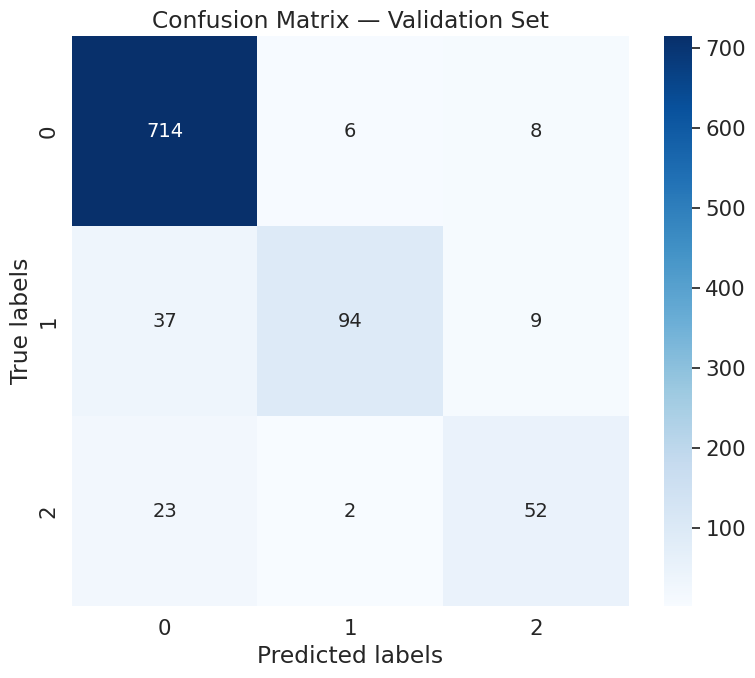

In [48]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, xb_ps, yb in val_loader:
        xb = xb.to(device)
        xb_ps = xb_ps.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb, xb_ps)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
val_rec = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

👉 Suggested window size: 70 time steps (threshold=0.25)


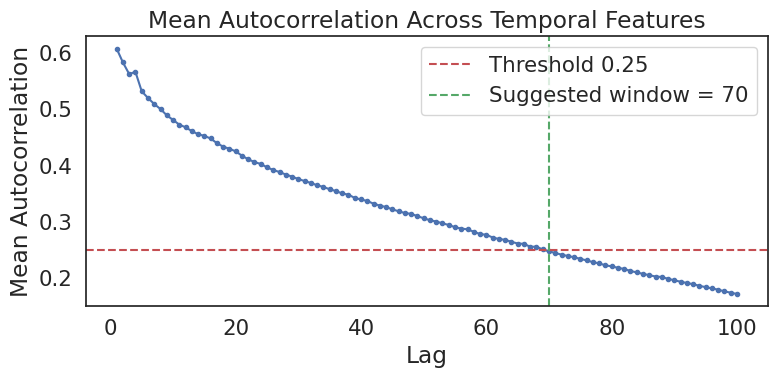

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === PARAMETRI MODIFICABILI ===
LAG_MAX = 100          # massimo lag da analizzare
THRESHOLD = 0.25        # soglia sotto la quale l’autocorrelazione è considerata "sparita"

# === CARICA IL DATASET ===
df = pd.read_csv("pirate_pain_train.csv")

# Seleziona solo le feature dinamiche (quelle temporali)
features = [c for c in df.columns if "joint_" in c or "pain_survey_" in c]

# === CALCOLA AUTOCORRELAZIONE MEDIA SU TUTTE LE FEATURE ===
autocorrs = []
for lag in range(1, LAG_MAX + 1):
    lag_corrs = []
    for f in features:
        try:
            lag_corr = df[f].autocorr(lag)
            if not np.isnan(lag_corr):
                lag_corrs.append(lag_corr)
        except:
            pass
    if lag_corrs:
        autocorrs.append(np.mean(lag_corrs))
    else:
        autocorrs.append(0)

autocorrs = np.array(autocorrs)

# === TROVA DOVE L’AUTOCORRELAZIONE MEDIA CADE SOTTO LA SOGLIA ===
below_threshold = np.where(autocorrs < THRESHOLD)[0]
if len(below_threshold) > 0:
    optimal_window = below_threshold[0] + 1  # +1 per compensare l’indice (partenza da lag=1)
else:
    optimal_window = LAG_MAX  # non è mai scesa sotto soglia

print(f"👉 Suggested window size: {optimal_window} time steps (threshold={THRESHOLD})")

# === GRAFICO ===
plt.figure(figsize=(8, 4))
plt.plot(range(1, LAG_MAX + 1), autocorrs, marker="o", markersize=3)
plt.axhline(THRESHOLD, color="r", linestyle="--", label=f"Threshold {THRESHOLD}")
plt.axvline(optimal_window, color="g", linestyle="--", label=f"Suggested window = {optimal_window}")
plt.title("Mean Autocorrelation Across Temporal Features")
plt.xlabel("Lag")
plt.ylabel("Mean Autocorrelation")
plt.legend()
plt.tight_layout()
plt.show()


# CROSS VALIDATION

In [ ]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 100          # Number of users for validation split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32         # Batch size
WINDOW_SIZE = 60       # Input window size
STRIDE = 20            # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64        # Neurons per layer
RNN_TYPE = 'LSTM'         # Type of RNN architecture
BIDIRECTIONAL = True    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.3       # Dropout probability
L1_LAMBDA = 0           # L1 penalty
L2_LAMBDA = 1e-4            # L2 penalty

LABEL_SMOOTHING= 0.05

GRADIENT_CLIPPING_MAX_NORM = 0.5

# Training utilities
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

In [ ]:
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, n_val_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda, l2_lambda, patience, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name="",
                            gradient_clipping_max_norm=None, pain_survey_embedding_dims=None):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['sample_index', 'label', 'pain_survey_X', 'n_X', 'joint_XX']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_users: Number of users for validation set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verboisty level
        seed: Random seed
        experiment_name: Name for experiment logging
        gradient_clipping_max_norm (float, optional): Max norm for gradient clipping. If None, no clipping.
        pain_survey_embedding_dims (list, optional): List of embedding dimensions for pain survey features.

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    label_col = 'label'
    user_id_col = 'sample_index'

    # Get number of classes from the global df 'label' column
    label_mapping = {
        'no_pain': 0,
        'low_pain': 1,
        'high_pain': 2,
    }
    num_classes = len(label_mapping)

    # Store initial weights to reset model for each split
    # Model is created inside the loop to ensure fresh state for each split
    initial_state = None

    # Define all feature columns (dynamic + static) for sequence building and scaling
    all_feature_cols = [col for col in df.columns if col.startswith('joint_')] + STATIC_COLS

    # Define pain survey columns
    pain_survey_cols = PAIN_SURVEY_FEATURES # Use global PAIN_SURVEY_FEATURES

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique user IDs and shuffle them with split-specific seed
        unique_users = df[user_id_col].unique()
        random.seed(seed + split_idx) # Use seed for reproducibility across splits
        random.shuffle(unique_users)

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users = unique_users[n_train_users:n_train_users + n_val_users]

        # Create deep copies for each split to avoid modifying the original df or other splits
        df_train_split = df[df[user_id_col].isin(train_users)].copy()
        df_val_split = df[df[user_id_col].isin(val_users)].copy()

        # Apply label mapping to convert string labels to integers for the current split
        df_train_split['label'] = df_train_split['label'].map(label_mapping)
        df_val_split['label'] = df_val_split['label'].map(label_mapping)

        if verbose > 0:
            print(f"  Training set shape: {df_train_split.shape}")
            print(f"  Validation set shape: {df_val_split.shape}")

        # Normalise all features (dynamic + static) using training set statistics for *this split*
        # Calculate min/max only from the training split of the current fold
        mins = df_train_split[all_feature_cols].min()
        maxs = df_train_split[all_feature_cols].max()

        # Apply normalization and ensure float32 for all numerical feature columns in all splits
        for col in all_feature_cols:
            # Handle potential division by zero if max equals min (constant column)
            divisor = (maxs[col] - mins[col])
            if divisor == 0: # If column is constant, assign 0 (or keep original value, depending on desired behavior)
                df_train_split[col] = 0.0
                df_val_split[col] = 0.0
            else:
                df_train_split[col] = ((df_train_split[col] - mins[col]) / divisor).astype(np.float32)
                df_val_split[col] = ((df_val_split[col] - mins[col]) / divisor).astype(np.float32)

        # Build sequences (main features and pain survey features)
        X_train_sequences, X_train_ps_sequences, y_train_split, seq_ids_train_split = build_sequences(df_train_split, window=window_size, stride=stride,
                                                                                                          feature_columns_to_extract=all_feature_cols,
                                                                                                          pain_survey_columns_to_extract=pain_survey_cols)
        X_val_sequences, X_val_ps_sequences, y_val_split, seq_ids_val_split     = build_sequences(df_val_split, window=window_size, stride=stride,
                                                                                                      feature_columns_to_extract=all_feature_cols,
                                                                                                      pain_survey_columns_to_extract=pain_survey_cols)

        if verbose > 0:
            print(f"  Training main sequences shape: {X_train_sequences.shape}")
            print(f"  Training PS sequences shape: {X_train_ps_sequences.shape}")
            print(f"  Validation main sequences shape: {X_val_sequences.shape}")
            print(f"  Validation PS sequences shape: {X_val_ps_sequences.shape}")

        # Create PyTorch datasets with combined features and pain survey features
        train_ds = TensorDataset(torch.from_numpy(X_train_sequences), torch.from_numpy(X_train_ps_sequences).long(), torch.from_numpy(y_train_split).long())
        val_ds   = TensorDataset(torch.from_numpy(X_val_sequences), torch.from_numpy(X_val_ps_sequences).long(), torch.from_numpy(y_val_split).long())

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # The input size for the RNN is the number of features in the combined main sequences
        rnn_input_size = X_train_sequences.shape[-1]

        # Initialise model inside the loop to ensure fresh state for each split
        model = RecurrentClassifier(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
            bidirectional=bidirectional,
            rnn_type=rnn_type,
            pain_survey_embedding_dims=pain_survey_embedding_dims, # Pass embedding dims
            conv1d_out_channels=CONV1D_OUT_CHANNELS,
            conv1d_kernel_size=CONV1D_KERNEL_SIZE,
            conv1d_padding=CONV1D_PADDING
        ).to(device)

        # Calculate class weights for this split's training data
        split_class_labels = np.unique(y_train_split)
        split_class_weights_np = compute_class_weight(
            class_weight='balanced',
            classes=split_class_labels,
            y=y_train_split
        )
        split_class_weights_tensor = torch.tensor(split_class_weights_np, dtype=torch.float32).to(device)

        # Define criterion for this split with calculated weights
        split_criterion = nn.CrossEntropyLoss(weight=split_class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=split_criterion, # Pass the split-specific criterion
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx),
            gradient_clipping_max_norm=gradient_clipping_max_norm # Pass gradient clipping parameter
        )

        # Store results for this split
        # Store the entire history for plotting purposes
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']

        # Also store the best single F1 score for mean/std calculation
        best_val_f1_in_split = max(training_history['val_f1'])
        best_scores[f"split_{split_idx}"] = best_val_f1_in_split

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}\u00b1{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [ ]:
# @title Training with k-fold
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores = k_shuffle_split_cross_validation_round_rnn(
    df=df,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="gru_baseline",
    n_val_users=N_VAL_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
    gradient_clipping_max_norm=GRADIENT_CLIPPING_MAX_NORM
)

In [ ]:
import shutil

# Assuming 'best_scores' and 'experiment_name' (from k-fold) are available
# 'best_scores' is a dictionary containing F1 scores for each split and their mean/std.
# 'experiment_name' for k-fold was 'gru_baseline'.

# Find the split with the highest F1 score
overall_best_f1_kfold = -1.0
best_split_index_kfold = -1

for i in range(K): # K is the number of splits from the cross-validation setup
    current_split_f1 = best_scores[f'split_{i}']
    if current_split_f1 > overall_best_f1_kfold:
        overall_best_f1_kfold = current_split_f1
        best_split_index_kfold = i

# Define the source path for the best model from the best split
source_model_filename = f"gru_baseline/split_{best_split_index_kfold}_model.pt"
source_model_path = os.path.join("models", source_model_filename)

# Define the destination path for the overall best model
destination_model_filename = f"best_kfold_model_f1_{overall_best_f1_kfold:.4f}.pt"
destination_model_path = os.path.join("models", destination_model_filename)

# Ensure the source model file exists before copying
if os.path.exists(source_model_path):
    # Copy the best model from the best split to a new, descriptive filename
    shutil.copyfile(source_model_path, destination_model_path)
    print(f"Overall best K-fold model (F1: {overall_best_f1_kfold:.4f} from split {best_split_index_kfold}) saved to: {destination_model_path}")
else:
    print(f"Error: Best model for split {best_split_index_kfold} not found at {source_model_path}")
    print("Please ensure the K-fold cross-validation training was executed successfully.")

# Update the best_performance variable for consistency if desired
best_performance = overall_best_f1_kfold


In [ ]:
# Create an inverse mapping from numeric labels back to string labels
inverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# The `test_ds` should already be defined correctly in n4g715TtSytf:
# test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(X_test_static).float())
# We don't redefine test_ds here.

# Create DataLoader for the test set (using the already defined test_ds)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# --- Load the best K-fold model ---
# The path to the best K-fold model was saved in the previous cell
best_kfold_model_path = destination_model_path # From the previous cell 9UQK2Wls-7BZ

# Instantiate a new model with the architecture used for the best K-fold run
# Parameters should match the best performing config from k-fold, which were set globally for the k-fold run
# (HIDDEN_SIZE, HIDDEN_LAYERS, RNN_TYPE='GRU', BIDIRECTIONAL=True)
model_for_prediction = RecurrentClassifier(
    input_size=X_test.shape[-1], # Use the last dimension of X_test, which already includes combined features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes, # Use the globally available num_classes
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE,
    pain_survey_embedding_dims=PAIN_SURVEY_EMBEDDING_DIMS, # Pass Conv1D parameters for consistent model instantiation
    conv1d_out_channels=CONV1D_OUT_CHANNELS,
    conv1d_kernel_size=CONV1D_KERNEL_SIZE,
    conv1d_padding=CONV1D_PADDING
).to(device)

# Load the state dictionary of the best K-fold model
model_for_prediction.load_state_dict(torch.load(best_kfold_model_path, map_location=device))
model_for_prediction.eval() # Set the loaded model to evaluation mode

all_test_predictions = []
# The seq_ids_test array generated by build_sequences already maps sequence predictions to sample_index.
# We will use this directly for grouping after predictions.

# Perform inference on the test set using the loaded best K-fold model
with torch.no_grad():
    for inputs_batch, pain_survey_inputs_batch in test_loader: # Unpack only inputs
        inputs_batch = inputs_batch.to(device)
        pain_survey_inputs_batch = pain_survey_inputs_batch.to(device)

        # Get model outputs
        outputs = model_for_prediction(inputs_batch, pain_survey_inputs_batch)

        # Get predicted class (the one with the highest probability)
        predictions = outputs.argmax(dim=1).cpu().numpy()

        all_test_predictions.extend(predictions)

# Combine seq_ids_test and predictions into a DataFrame
predictions_df = pd.DataFrame({
    'sample_index': seq_ids_test, # Use the global seq_ids_test array
    'predicted_label_numeric': all_test_predictions
})

# Group by sample_index and determine the final prediction (e.g., by taking the mode)
# Using pandas Series.mode() which is typically more robust for Series.
# Add a check for empty group to avoid IndexError.
final_predictions_grouped = predictions_df.groupby('sample_index')['predicted_label_numeric'].apply(
    lambda x: x.mode()[0] if not x.empty else np.nan # If a group is empty, assign NaN
)
final_predictions_df = final_predictions_grouped.reset_index()
final_predictions_df.columns = ['sample_index', 'predicted_label_numeric']

# Map numeric predictions back to string labels
final_predictions_df['predicted_label'] = final_predictions_df['predicted_label_numeric'].map(inverse_label_mapping)

# Define the output filename
output_filename = 'pirate_pain_predictions.csv'

# Save the DataFrame to a CSV file
final_predictions_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"Predictions saved to {output_filename}")
display(final_predictions_df.head())

# The file is already saved to Google Drive because the current working directory
# is set to '/gdrive/My Drive/Challenge1-Datasets'. No need to copy it again.
print(f"File '{output_filename}' is already saved to Google Drive at '{current_dir}/{output_filename}'")

In [ ]:
# @title Plot History
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

In [ ]:
# @title Plot Confusion Matrix for Best K-fold Validation Set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Re-create the validation data for the best performing split
label_col = 'label'
user_id_col = 'sample_index'
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}
# num_classes should be available globally, but we can re-derive it safely
num_classes_derived = len(label_mapping)

# Re-run the user splitting logic for the best split
unique_users = df[user_id_col].unique()
random.seed(SEED + best_split_index_kfold) # Use the same seed as that split
random.shuffle(unique_users)

n_train_users_best_split = len(unique_users) - N_VAL_USERS
train_users_best_split = unique_users[:n_train_users_best_split]
val_users_best_split = unique_users[n_train_users_best_split:n_train_users_best_split + N_VAL_USERS]

df_train_split_best = df[df[user_id_col].isin(train_users_best_split)].copy()
df_val_split_best = df[df[user_id_col].isin(val_users_best_split)].copy()

# Apply label mapping
df_train_split_best['label'] = df_train_split_best['label'].map(label_mapping)
df_val_split_best['label'] = df_val_split_best['label'].map(label_mapping)

# Dynamically identify all feature columns (dynamic + static) for scaling and sequence building for this split
all_feature_cols_best_split = [col for col in df_train_split_best.columns if col.startswith('joint_')] + STATIC_COLS

# Pain survey columns
pain_survey_cols_cm = PAIN_SURVEY_FEATURES

# Normalize features using training set statistics for this specific split
mins_best_split = df_train_split_best[all_feature_cols_best_split].min()
maxs_best_split = df_train_split_best[all_feature_cols_best_split].max()

for col in all_feature_cols_best_split:
    divisor = (maxs_best_split[col] - mins_best_split[col])
    if divisor == 0: # If column is constant, assign 0.0 for consistent typing
        df_train_split_best[col] = 0.0
        df_val_split_best[col] = 0.0
    else:
        df_train_split_best[col] = ((df_train_split_best[col] - mins_best_split[col]) / divisor).astype(np.float32)
        df_val_split_best[col] = ((df_val_split_best[col] - mins_best_split[col]) / divisor).astype(np.float32)

# Build sequences (main features and pain survey features)
X_val_sequences_best_split, X_val_ps_sequences_best_split, y_val_best_split, seq_ids_val_best_split = build_sequences(
    df_val_split_best, WINDOW_SIZE, STRIDE,
    feature_columns_to_extract=all_feature_cols_best_split,
    pain_survey_columns_to_extract=pain_survey_cols_cm
)

# Create DataLoader for the validation set of the best split
val_ds_best_split = TensorDataset(torch.from_numpy(X_val_sequences_best_split), torch.from_numpy(X_val_ps_sequences_best_split).long(), torch.from_numpy(y_val_best_split).long())
val_loader_best_split = make_loader(val_ds_best_split, BATCH_SIZE, shuffle=False, drop_last=False)

# Load the best K-fold model (destination_model_path should be available from earlier execution)
model_for_conf_matrix = RecurrentClassifier(
    input_size=X_val_sequences_best_split.shape[-1], # Use the dynamically determined number of combined features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes_derived,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE,
    pain_survey_embedding_dims=PAIN_SURVEY_EMBEDDING_DIMS, # Pass embedding dims
    conv1d_out_channels=CONV1D_OUT_CHANNELS,
    conv1d_kernel_size=CONV1D_KERNEL_SIZE,
    conv1d_padding=CONV1D_PADDING
).to(device)

model_for_conf_matrix.load_state_dict(torch.load(destination_model_path, map_location=device))
model_for_conf_matrix.eval()

# Collect predictions and ground truth labels for the best split's validation set
val_preds_best_split, val_targets_best_split = [], []
with torch.no_grad():
    for xb, xb_ps, yb in val_loader_best_split:
        xb = xb.to(device)
        xb_ps = xb_ps.to(device)
        logits = model_for_conf_matrix(xb, xb_ps)
        preds = logits.argmax(dim=1).cpu().numpy()
        val_preds_best_split.append(preds)
        val_targets_best_split.append(yb.numpy())

val_preds_best_split = np.concatenate(val_preds_best_split)
val_targets_best_split = np.concatenate(val_targets_best_split)

# Calculate overall validation metrics for this split
val_acc = accuracy_score(val_targets_best_split, val_preds_best_split)
val_prec = precision_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
val_rec = recall_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
print(f"Metrics for Validation Set of Best K-fold Split (Fold {best_split_index_kfold+1}):")
print(f"Accuracy: {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall: {val_rec:.4f}")
print(f"F1 score: {val_f1:.4f}")

# Generate confusion matrix
cm_best_split = confusion_matrix(val_targets_best_split, val_preds_best_split)

# Map numeric labels back to string labels for better readability in the plot
inverse_label_mapping = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
class_labels = [inverse_label_mapping[i] for i in sorted(inverse_label_mapping.keys())]

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm_best_split, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels
           )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix — Validation Set (Best K-fold Split Fold {best_split_index_kfold+1})')
plt.tight_layout()
plt.show()

# HYPERPARAMETER TUNING

In [ ]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
# @title Grid search
%%time
# Define parameters to search
param_grid = {
    'window_size': [60, 90],
    'stride': [10, 15, 30],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL,
    'pain_survey_embedding_dims': pain_survey_embedding_dims
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'n_val_users': N_VAL_USERS,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED,
    'gradient_clipping_max_norm': GRADIENT_CLIPPING_MAX_NORM # Pass gradient clipping parameter
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)